In [54]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [64]:
### TODO: Write data loaders for training, validation, and test sets
## Specify appropriate transforms, and batch_sizes

batch_size = 16
workers = 2

dataroot = 'data/celebs'

dset = datasets.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                    )]))
print(dset)
train_set, test_set, val_set = torch.utils.data.random_split(dset, [90000, 30000, 35720])

loaders = list(map(lambda x: torch.utils.data.DataLoader(x, batch_size=batch_size,
                                         shuffle=True, num_workers=workers),[train_set, test_set, val_set]))

Dataset ImageFolder
    Number of datapoints: 155720
    Root location: data/celebs
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [65]:
class_names = dset.classes
nb_classes = len(class_names)

print("Number of classes:", nb_classes)
print("\nClass names: \n\n", class_names)

Number of classes: 8

Class names: 

 ['blackmen', 'blackwomen', 'blondmen', 'blondwomen', 'caucasianmen', 'caucasianwomen', 'tannedmen', 'tannedwomen']


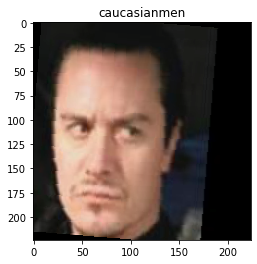

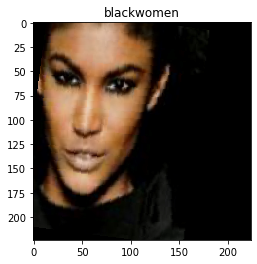

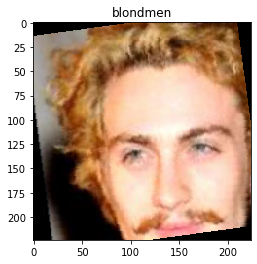

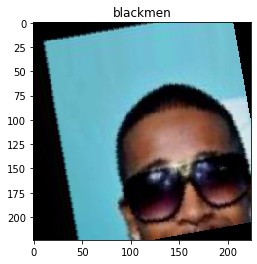

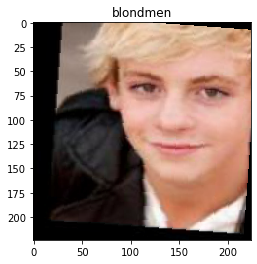

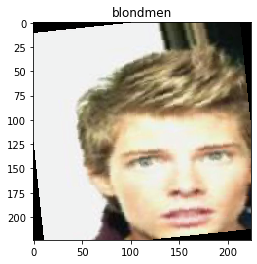

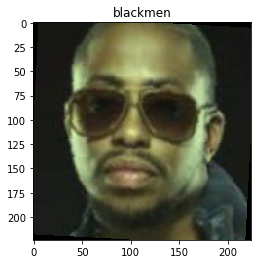

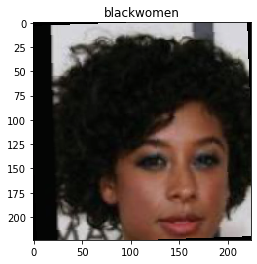

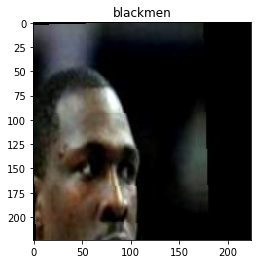

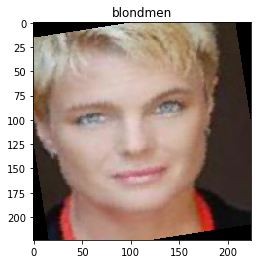

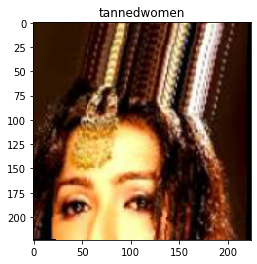

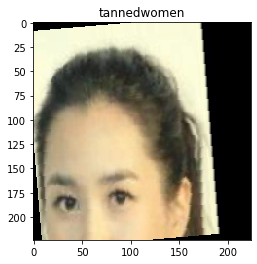

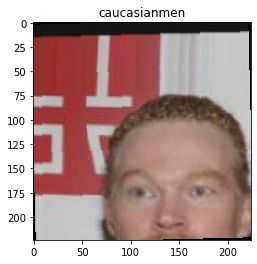

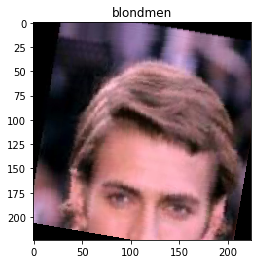

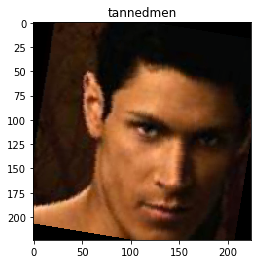

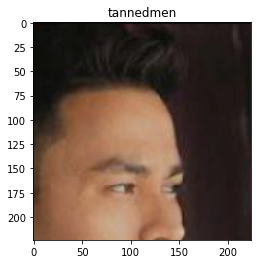

In [66]:
# Get a batch of training data
inputs, classes = next(iter(loaders[2]))

for image, label in zip(inputs, classes): 
    image = image.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)
     
    fig = plt.figure(figsize=(16,4))
    plt.imshow(image)
    plt.title(class_names[label])

In [67]:
import torch.nn as nn
import torch.nn.functional as F

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.conv3 = nn.Conv2d(32, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 256, 3)
        
        self.fc1 = nn.Linear(256 * 6 * 6, 8)
        self.max_pool = nn.MaxPool2d(2, 2,ceil_mode=True)
        
        self.dropout = nn.Dropout(0.20)
        
        self.conv_bn1 = nn.BatchNorm2d(224,3)
        self.conv_bn2 = nn.BatchNorm2d(16)
        self.conv_bn3 = nn.BatchNorm2d(32)
        self.conv_bn4 = nn.BatchNorm2d(64)
        self.conv_bn5 = nn.BatchNorm2d(128)
        self.conv_bn6 = nn.BatchNorm2d(256)
        
    def forward(self, x):
        ## Define forward behavior
        x = F.relu(self.conv1(x))
        x = self.max_pool(x)
        x = self.conv_bn2(x)

        x = F.relu(self.conv2(x))
        x = self.max_pool(x)
        x = self.conv_bn3(x)

        x = F.relu(self.conv3(x))
        x = self.max_pool(x)
        x = self.conv_bn4(x)

        x = F.relu(self.conv4(x))
        x = self.max_pool(x)
        x = self.conv_bn5(x)

        x = F.relu(self.conv5(x))
        x = self.max_pool(x)
        x = self.conv_bn6(x)

        x = x.view(-1, 256 * 6 * 6)

        x = self.dropout(x)
        x = self.fc1(x)
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)
# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=9216, out_features=8, bias=True)
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (conv_bn1): BatchNorm2d(224, eps=3, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_bn6): BatchNorm2d(25

I started out  looking for best practices in architecting CNNs, stumbled upon this article https://algorithmia.com/blog/convolutional-neural-nets-in-pytorch

After some further searching and combining different setups I decided to use 5 convolution layers with standard values for kernel (3), stride (1) and padding (0), maxpooling, batch normalization, dropout and ReLu in the forward function
In the succeeding convolution layers I doubled the input/output ratio's and finally I concluded with a fully connected linear layer of 256 to 8 classes, our 'racial types' ['blackmen', 'blackwomen', 'blondmen', 'blondwomen', 'caucasianmen', 'caucasianwomen', 'tannedmen', 'tannedwomen']

In [68]:
import torch.optim as optim

### TODO: select loss function
criterion_scratch = nn.CrossEntropyLoss()

### TODO: select optimizer
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001)

In [69]:
# the following import is required for training to be robust to truncated images
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders[0]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
                        # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss
            # update training loss
            train_loss += ((1 / (batch_idx + 1)) * (loss.data - train_loss))            

        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders[2]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            with torch.no_grad():
                output = model(data)
            loss = criterion(output, target)
            valid_loss += ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
           
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}). Saving model...'.format(valid_loss_min, valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss          
    # return trained model
    return model


# train the model
model_scratch = train(15, loaders, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 1.089968 	Validation Loss: 0.703404
Validation loss decreased (inf --> 0.703404). Saving model...
Epoch: 2 	Training Loss: 0.615091 	Validation Loss: 0.467107
Validation loss decreased (0.703404 --> 0.467107). Saving model...
Epoch: 3 	Training Loss: 0.454614 	Validation Loss: 0.337066
Validation loss decreased (0.467107 --> 0.337066). Saving model...
Epoch: 4 	Training Loss: 0.359494 	Validation Loss: 0.306111
Validation loss decreased (0.337066 --> 0.306111). Saving model...
Epoch: 5 	Training Loss: 0.304885 	Validation Loss: 0.258946
Validation loss decreased (0.306111 --> 0.258946). Saving model...
Epoch: 6 	Training Loss: 0.267090 	Validation Loss: 0.228734
Validation loss decreased (0.258946 --> 0.228734). Saving model...
Epoch: 7 	Training Loss: 0.236071 	Validation Loss: 0.190325
Validation loss decreased (0.228734 --> 0.190325). Saving model...
Epoch: 8 	Training Loss: 0.217599 	Validation Loss: 0.202054
Epoch: 9 	Training Loss: 0.196280 	Validation Lo

<All keys matched successfully>

In [70]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders[1]):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# call test function    
test(loaders, model_scratch, criterion_scratch, use_cuda)

Test Loss: 0.126616


Test Accuracy: 95% (28552/30000)


Not bad at all...testing with a factor 10 less data gave an accuracy of 68%, 

In [78]:
batch_size = 16
workers = 2

dataroot = 'data/celebstestset'

dtestset = datasets.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                    transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.RandomHorizontalFlip(), # randomly flip and rotate
                                    transforms.RandomRotation(10),
                                    transforms.ToTensor(),
                                    transforms.Normalize(
                                        mean=[0.485, 0.456, 0.406],
                                        std=[0.229, 0.224, 0.225]
                                    )]))
print(dtestset)

testloader = torch.utils.data.DataLoader(dtestset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

Dataset ImageFolder
    Number of datapoints: 40489
    Root location: data/celebstestset
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=(-10, 10), resample=False, expand=False)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [80]:
def test2(loader, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loader):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [81]:
test2(testloader, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.136830


Test Accuracy: 52% (21411/40489)


In [ ]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 

use_cuda = torch.cuda.is_available()

## TODO: Specify model architecture 
model_transfer = models.resnet152(pretrained=True)

for param in model_transfer.parameters():
    param.requires_grad = False
    
model_transfer.fc = nn.Linear(2048, 8, bias=True)    
fc_parameters = model_transfer.fc.parameters()

for param in fc_parameters:
    param.requires_grad = True
    
if use_cuda:
    model_transfer = model_transfer.cuda()
    print(model_transfer)

In [ ]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()
optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

In [76]:
# train the model

print(use_cuda)
n_epochs = 10

def train(n_epochs, loader, model, optimizer, criterion, use_cuda, save_path):
    valid_loss_min = np.Inf
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        #train_loss = 0.0
        model.train()
        for batch_i, (data, target) in enumerate(loader[0]):
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_i + 1)) * (loss.data - train_loss))
            
            if batch_i % 100 == 0:
                print('Epoch %d, Batch %d loss: %.6f' %
                  (epoch, batch_i + 1, train_loss))
                
        model.eval()
        for batch_i, (data, target) in enumerate(loader[2]):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_i + 1)) * (loss.data - valid_loss))

            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model'.format(
            valid_loss_min,
            valid_loss))
            valid_loss_min = valid_loss
            
    return model

# train the model
model_transfer = train(n_epochs, loaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

False
Epoch 1, Batch 1 loss: 1.748539
Epoch 1, Batch 101 loss: 1.752999


KeyboardInterrupt: 

In [52]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))

<All keys matched successfully>

In [53]:
test(loaders, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.113536


Test Accuracy: 66% (662/1000)


So, nothing gained as this point. Seems the pretrained model had to learn all over again.